In [7]:
import random
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, struct, col
from pyspark.sql.types import ArrayType, StructType, StructField, IntegerType
import matplotlib.pyplot as plt


In [23]:

class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Utility function to find orientation of ordered triplet (p, q, r).
# 0 --> p, q, r are collinear
# 1 --> Clockwise
# 2 --> Counterclockwise
def orientation(p, q, r):
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0  # collinear
    elif val > 0:
        return 1  # clockwise
    else:
        return 2  # counterclockwise

# Function to compute convex hull using the algorithm provided
def compute_convex_hull(points):
    points = [Point(p['x'], p['y']) for p in points]

    n = len(points)
    if n < 3:
        return [(p.x, p.y) for p in points]  # Convex hull is the same as the points if less than 3 points

    hull = []

    # Find the leftmost point
    l = 0
    for i in range(1, n):
        if points[i].x < points[l].x:
            l = i

    p = l
    while True:
        hull.append(points[p])

        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p], points[i], points[q]) == 2:
                q = i

        p = q

        if p == l:
            break

    return [(p.x, p.y) for p in hull]


In [24]:

# Initialize Spark session
spark = SparkSession.builder.appName("ConvexHullPerParticle").getOrCreate()

In [26]:
# Generate sample data with 1,000,000 data points
num_points = 1000000
num_particles = 10000  # Limiting to 4 particles for visualization

# Set seed for reproducibility
random.seed(0)
data = [(random.randint(1, num_particles), random.randint(0, 500), random.randint(0, 500)) for _ in range(num_points)]


In [27]:

# Measure the execution time
start_time = time.time()

# Create DataFrame
columns = ["particle_id", "x", "y"]
df = spark.createDataFrame(data, columns)

# Group by particle_id and collect points
grouped_df = df.groupBy("particle_id").agg(
    collect_list(struct("x", "y")).alias("points")
)

# Register the UDF
hull_schema = ArrayType(StructType([StructField("x", IntegerType()), StructField("y", IntegerType())]))
compute_convex_hull_udf = spark.udf.register("compute_convex_hull", compute_convex_hull, hull_schema)

# Apply the UDF
result_df = grouped_df.withColumn("convex_hull", compute_convex_hull_udf(col("points")))

# Show the results (10 only)
result_df.show(10, truncate=False)
# result = result_df.select("particle_id", "points", "convex_hull").collect()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")



+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# Check if any point belongs to more than one particle that is not possible
result_df.groupBy("particle_id").count().where(col("count") > 1).show()

+-----------+-----+
|particle_id|count|
+-----------+-----+
+-----------+-----+



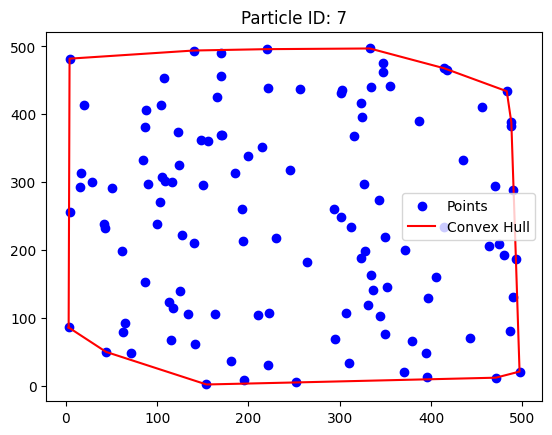

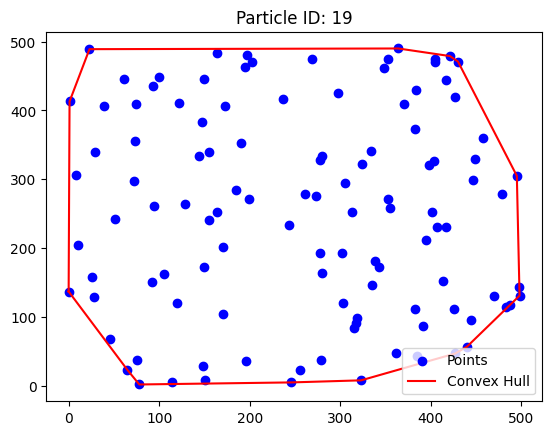

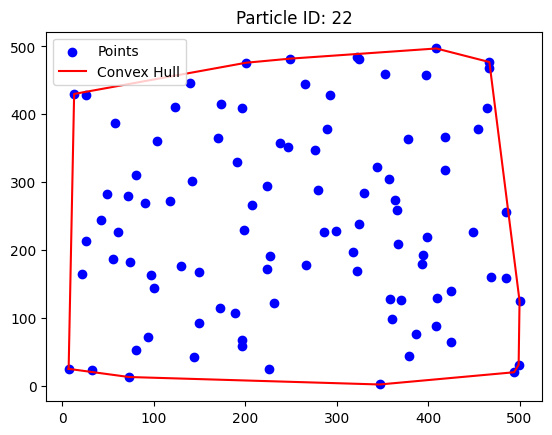

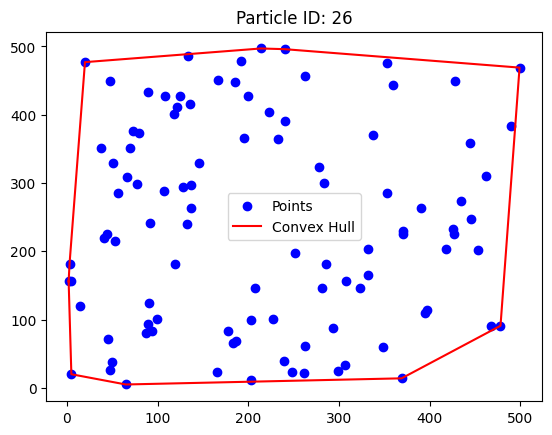

In [34]:
# Draw convex hulls of the first 4 particles in separate plots
result = result_df.select("particle_id", "points", "convex_hull").collect()
for i in range(4):
    particle_id = result[i]["particle_id"]
    points = result[i]["points"]
    hull = result[i]["convex_hull"]

    # Extract x and y coordinates
    x, y = zip(*points)
    hull_x, hull_y = zip(*hull)

    # Plot
    plt.figure()
    plt.scatter(x, y, color="blue", label="Points")
    plt.plot(hull_x + (hull_x[0],), hull_y + (hull_y[0],), color="red", label="Convex Hull")
    plt.title(f"Particle ID: {particle_id}")
    plt.legend()
    plt.show()
